<a href="https://colab.research.google.com/github/kfahn22/computer-vision-course/blob/labeled-image-demo/OWLV2_labeled_image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating a labeled dataset using OWLv2

In this notebook, we are going to demo how to create a dataset of labeled images using OWLv2. Like its predecessor OWL-ViT, OWLv2 is a zero-shot text-conditioned object detection model. OWL-ViT was introduced in [Simple Open-Vocabulary Object Detection with Vision Transformers](https://arxiv.org/abs/2205.06230) by Minderer, et. al., and OWLv2 was introduced in [Scaling Open-Vocabulary Object Detection](https://arxiv.org/pdf/2306.09683.pdf) by Minderer, et. al.

You can learn more about the OWLv2 model [here](https://huggingface.co/docs/transformers/model_doc/owlv2).


Run this cell if you have generated a large dataset. It is unnecessary for this toy example.

In [38]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


First, let's install the dependencies.

In [39]:
!pip install -q transformers huggingface_hub datasets

Let's log into the Hugging Face Hub with our WRITE access token.

In [40]:
from huggingface_hub import notebook_login

notebook_login()

We need CUDA to run this notebook.

In [41]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Let's write a function to use Owlv2 to detect the objects in an image and return a list of object names.

In [42]:
# Process the image and retrieve the significant texts
def get_predictions(image, text_queries, model, processor, score_threshold):
    # Process the image, and text queries
    inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

    # Set model in evaluation mode
    model = model.to(device)
    model.eval()

    # Get predictions
    with torch.no_grad():
      outputs = model(**inputs)

    # Get prediction logits
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()

    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()

    significant_labels = []
    for score, label in zip(scores, labels):
      if score < score_threshold:
        continue
      else:
        significant_labels.append(text_queries[label])
    return list(set(significant_labels))

Let's add a helper function to generate a label for the image. If the model does not detect any objects, the label be "None."

In [43]:
def add_labels(labels):
  if len(labels) == 0:
    text = "None"
    return text
  elif len(labels) == 1:
    text = f'{labels[0]}'
    return text
  elif len(labels) > 1:
    text = f'{labels[0]}'
  for item in labels[1:]:
      text += ", " + item
  return text

We are all set to process the images!  We will pass our images and a list of text queries to the model and will get back a list of detected objects. It is important to note that we also need to set a score threshold for how confident the model should be that a  object has been detected.

*Pro Tip:*

  You might need to experiment with different values for the score threshold to prevent false positives.

In [56]:
import os
from datasets import Dataset
import PIL
from PIL import Image
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# Set the path to the images
path = "/content/images"

# Create a list of images
images = os.listdir(path)

# Create a list of text queries
text_queries = ["table", "chair", "book", "fireplace", "plant", "tree", "light", "window", "basketball", "soccer ball", "volleyball", "hola hoop", "car", "onion", "potato", "cabbage", "carrot", "apple", "pear", "banana", "orange", "pineapple", "watermelon", "tomatoes"]

# Set the number of images to generate
num_images = 15

# Set the score threshold
score_threshold = 0.3

# Write a function to add images to the dataset
def add_images(idx, text_queries):
    processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
    model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

    # Load example image
    image= Image.open(f'{path}/{idx}.jpeg')

    # Get predictions
    labels = get_predictions(image, text_queries, model, processor, score_threshold)
    label = add_labels(labels)
    # Add image and label to the dataset
    return {
        "image": image,
        "label": label,
    }

def generate_entries():
    for i in range(num_images):
        yield add_images(i, text_queries)

In [57]:
username = "kfahn"
repo_id = "labeled_images_demo"

# Create a dataset from the generator
ds = Dataset.from_generator(generate_entries)
ds.push_to_hub(f'{username}/{repo_id}')

Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/310 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kfahn/labeled_images_demo/commit/72fc7b9c9c717f9abb526073b5a486824e2aa578', commit_message='Upload dataset', commit_description='', oid='72fc7b9c9c717f9abb526073b5a486824e2aa578', pr_url=None, pr_revision=None, pr_num=None)

In [58]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('kfahn/labeled_images_demo')


Generating train split:   0%|          | 0/15 [00:00<?, ? examples/s]

Let's take a look at a couple of the images and labels in our new dataset. If we look at the first image, which shows a table and chairs in front of a window, the label seems spot on.

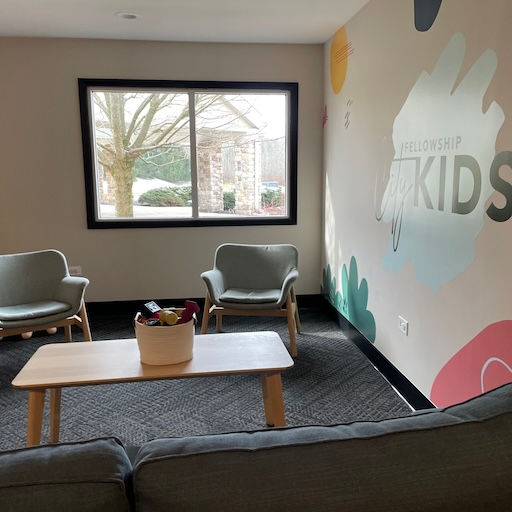

In [59]:
dataset["train"][0]["image"]

In [60]:
dataset["train"][0]["label"]

'pear, window, table, chair'